# Week 4_2: Ridge regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

In [1]:
import graphlab
import numpy as np

[WARNING] Unable to write current GraphLab Create license to /Users/jcj/.graphlab/config. Ensure that this user account has write permission to /Users/jcj/.graphlab/config to save the license for offline use.
[INFO] This non-commercial license of GraphLab Create is assigned to chengjun@chem.ku.dk and will expire on January 27, 2017. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-95655 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1455271694.log
[INFO] GraphLab Server Version: 1.8.1
[WARNING] Unable to create session in specified location: '/Users/jcj/.graphlab/artifacts'. Using: '/var/tmp/graphlab-jcj/95655/tmp_session_df228808-b92a-462c-8f69-4b29f60a8cd2'


In [5]:
sales = graphlab.SFrame('kc_house_data.gl/')

## Import useful functions from previous notebook

In [2]:
def get_numpy_data(data_sframe, features, output):
    """
    features is a list of features.
    output is a list or a string.
    """
    data_sframe['constant'] = 1
    features = data_sframe[['constant']+features]
    features_matrix = features.to_numpy()
    
    output_array = data_sframe[output].to_numpy()
    return (features_matrix, output_array)

In [3]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

## Computing the Derivative

In [4]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    if feature_is_constant:
        feature_derivative = 2 * np.dot(errors, feature)
    else:
        feature_derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    return (feature_derivative)

In [6]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights)
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.65541667824e+13
-5.65541667824e+13

-22446749336.0
-22446749336.0


## Gradient Descent

In [7]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) 
    n_iteration = 0
    while n_iteration < max_iterations:
        # compute the predictions using your predict_output() function
        predictions = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        #errors = output - predictions
        errors = predictions - output

        for i in xrange(len(weights)):
        # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
        # compute the derivative for weight[i].
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            #print derivative
            weights[i] = weights[i] - step_size * derivative
            
        n_iteration += 1
    return weights

## Visualizing effect of L2 penalty

In [8]:
train_data,test_data = sales.random_split(.8,seed=0)

In [9]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [10]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, 
                                                             output, 
                                                             initial_weights=[0.0, 0.0], 
                                                             step_size=1e-12, 
                                                             l2_penalty=0.0, 
                                                             max_iterations=1000)
print simple_weights_0_penalty


[ -1.63113501e-01   2.63024369e+02]


In [11]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, 
                                                             output, 
                                                             initial_weights=[0., 0.], 
                                                             step_size=1e-12, 
                                                             l2_penalty=1e11, 
                                                             max_iterations=1000)
print simple_weights_high_penalty

[   9.76730383  124.57217565]


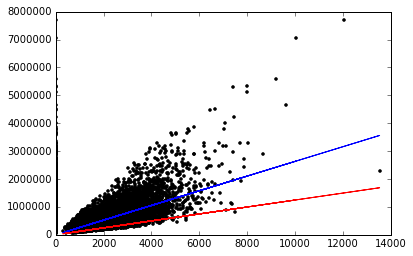

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix, output,'k.',
        simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [13]:
simple_feature_matrix

array([[  1.00000000e+00,   1.18000000e+03],
       [  1.00000000e+00,   2.57000000e+03],
       [  1.00000000e+00,   7.70000000e+02],
       ..., 
       [  1.00000000e+00,   1.53000000e+03],
       [  1.00000000e+00,   1.60000000e+03],
       [  1.00000000e+00,   1.02000000e+03]])

In [14]:
def get_rss(feature_matrix, weights, output):
    predicted_test_output = predict_output(feature_matrix, weights)
    rss = np.sum((predicted_test_output - output)**2)
    return rss

In [15]:
rss_1 = get_rss(simple_test_feature_matrix, [0., 0.], test_output)
rss_2 = get_rss(simple_test_feature_matrix, simple_weights_0_penalty, test_output)
rss_3 = get_rss(simple_test_feature_matrix, simple_weights_high_penalty, test_output)
print rss_1
print rss_2
print rss_3

1.78427328252e+15
2.75723634598e+14
6.94642100914e+14


## Running a multiple regression with L2 penalty

In [16]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [17]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, 
                                                             output, 
                                                             initial_weights=[0., 0., 0.], 
                                                             step_size=1e-12, 
                                                             l2_penalty=0, 
                                                             max_iterations=1000)
print multiple_weights_0_penalty

[  -0.35743482  243.0541689    22.41481594]


In [18]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, 
                                                             output, 
                                                             initial_weights=[0., 0., 0.], 
                                                             step_size=1e-12, 
                                                             l2_penalty=1e11, 
                                                             max_iterations=1000)
print multiple_weights_high_penalty

[  6.7429658   91.48927361  78.43658768]


In [19]:
rss_1 = get_rss(test_feature_matrix, [0., 0., 0.], test_output)
rss_2 = get_rss(test_feature_matrix, multiple_weights_0_penalty, test_output)
rss_3 = get_rss(test_feature_matrix, multiple_weights_high_penalty, test_output)
print rss_1
print rss_2
print rss_3

1.78427328252e+15
2.74067618287e+14
5.0040480058e+14


In [20]:
predict_output(test_feature_matrix, multiple_weights_0_penalty)[0] - test_output[0]

77465.476464743959

In [21]:
predict_output(test_feature_matrix, multiple_weights_high_penalty)[0] - test_output[0]

-39546.469695141423